In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Install dependencies
!pip install dlib
!pip install deepface # Uses VGGFace2 for age and sex classifications
#!pip install openface
!apt-get install -y cmake
!pip install insightface # used for ArcFace
!pip install mxnet
!pip install onnxruntime
!pip install opencv-python

import cv2
import glob
import numpy as np
import os
from google.colab import files
from io import BytesIO
from PIL import Image
from google.colab.patches import cv2_imshow
from deepface import DeepFace

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
# Clone and build OpenFace
!git clone https://github.com/cmusatyalab/openface.git
%cd openface
!python setup.py install

## Initialize OpenFace
import openface
import dlib

# Directory for dlib models
dlib_model_dir = '/content/openface/models/dlib'

# Create the model directory if it doesn't exist
if not os.path.exists(dlib_model_dir):
    os.makedirs(dlib_model_dir)

# Define the model file paths
model_file_bz2 = os.path.join(dlib_model_dir, 'shape_predictor_68_face_landmarks.dat.bz2')
model_file_dat = os.path.join(dlib_model_dir, 'shape_predictor_68_face_landmarks.dat')

# Download and unzip the model file if it doesn't exist
if not os.path.exists(model_file_dat):
    if not os.path.exists(model_file_bz2):
        !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O {model_file_bz2}
    !bzip2 -d {model_file_bz2}
else:
    print("dlib model file already exists.")

# Update the paths for dlib and OpenFace models
dlib_face_predictor = os.path.join(dlib_model_dir, 'shape_predictor_68_face_landmarks.dat')
openface_model_dir = '/content/openface/models/openface'
network_model = os.path.join(openface_model_dir, 'nn4.small2.v1.t7')

# Initialize OpenFace models
align = openface.AlignDlib(dlib_face_predictor)
net = openface.TorchNeuralNet(network_model, 96)

Cloning into 'openface'...
remote: Enumerating objects: 4848, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 4848 (delta 1), reused 1 (delta 0), pack-reused 4840
Receiving objects: 100% (4848/4848), 24.02 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (2909/2909), done.
/content/openface/openface/openface
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-pack

In [ ]:
## Setup and Initialize ArcFace
from insightface.app import FaceAnalysis
from scipy.spatial.distance import cosine

# Initialize the InsightFace model with ArcFace
app = FaceAnalysis()
app.prepare(ctx_id=-1, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
## Setup Capture Photo through Device
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

frame_counter = 0
def take_photo(directory='/content/face_images', quality=0.8):
    global frame_counter
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, f'face_frame_{frame_counter + 1}.jpg')

    js_code = """
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    """
    try:
        display(Javascript(js_code))
        data_url = eval_js('takePhoto({})'.format(quality))
        binary_data = b64decode(data_url.split(',')[1])
        with open(filename, 'wb') as file:
            file.write(binary_data)
        frame_counter += 1
        return filename
    except Exception as err:
        print(f"Error taking photo: {err}")
        return None

In [ ]:
## Function Declarations

# Sace the uploaded files to Google Colab environment
def save_uploaded_files(uploaded_files):
    paths = []
    for filename, data in uploaded_files.items():
        path = f"/content/{filename}"
        with open(path, 'wb') as f:
            f.write(data)
        paths.append(path)
    return paths


# def save_uploaded_files(filename, data):
#     path = f"/content/{filename}"
#     with open(path, 'wb') as f:
#         f.write(data)
#     return path


# Embed images through each person
def process_embeddings_for_person(name, image_data, is_path=False):
    embeddings = []
    if is_path:
        for image_path in image_data:
            embedding = compute_embedding(image_path)
            if embedding is not None:
                embeddings.append(embedding)
    else:
        for filename, data in image_data.items():
            image_path = save_uploaded_files(filename, data)
            embedding = compute_embedding(image_path)
            if embedding is not None:
                embeddings.append(embedding)
    return name, embeddings

# Function to compute embedding for a given image path
def compute_embedding(image_path):
    image = cv2.imread(image_path)
    faces = app.get(image)
    if faces:
        return faces[0]['embedding']
    else:
        return None

# Function to detect face using OpenFace and draw a detection box
def detect_face_openface(image_path):
    img = cv2.imread(image_path)
    faces = align.getAllFaceBoundingBoxes(img)
    for face in faces:
        cv2.rectangle(img, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
    return img

# Delete Saved Images
def reset_saved_images():
    file_types = ['/content/*.jpg', '/content/*.jpeg', '/content/*.png', '/content/*.webp']
    for file_type in file_types:
        files = glob.glob(file_type)
        for f in files:
            if os.path.isfile(f):
                os.remove(f)
    print("All saved images have been deleted.")

# Define colors for different facial features
colors = {
    'jawline': (255, 0, 0),    # Blue
    'eyebrows': (0, 255, 0),   # Green
    'nose': (0, 255, 255),     # Yellow
    'eyes': (0, 0, 255),       # Red
    'lips': (255, 255, 0),     # Cyan
}

# Function to draw facial landmarks
def draw_feature(image, facial_landmarks, feature_indices, feature_color):
    for i in feature_indices:
        cv2.circle(image, (int(facial_landmarks[i][0]), int(facial_landmarks[i][1])), 2, feature_color, -1)

def concatenate_images(images, display_height=500):
    # Resize images to have the same height
    resized_images = []
    for img in images:
        height, width = img.shape[:2]
        aspect_ratio = width / height
        new_height = display_height
        new_width = int(new_height * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_height))
        resized_images.append(resized_img)

    # Concatenate images horizontally
    concatenated_image = np.hstack(resized_images)
    return concatenated_image

In [ ]:
from ipywidgets import Button, HBox, VBox
from IPython.display import display, clear_output

people_embeddings = {}
# Function to upload images for embedding
def upload_for_embedding():
    option = input("'Manual' or 'Hardcode' Embedding? ")
    if option.lower() == "manual":
      number_of_people = int(input("Enter the number of people: "))
      for i in range(number_of_people):
          name = input(f"Enter the name for person {i+1}: ")
          if name.lower() == "exit":
            print("Exiting Process")
            break

          print(f"Upload images for {name}")
          uploaded_images = files.upload()
          print(uploaded_images.keys())
          _, embeddings = process_embeddings_for_person(name, uploaded_images)
          people_embeddings[name] = embeddings
    elif option.lower() == "hardcode":
        # Define the list of people and their corresponding folder names
        people_folders = [
            ("Jennifer Aniston", "Jennifer_Aniston"),
            ("David Schwimmer", "David_Schwimmer"),
            ("Courtney Cox", "Courtney_Cox"),
            ("Matthew Perry", "Matthew_Perry"),
            ("Lisa Kudrow", "Lisa_Kudrow"),
            ("Matt LeBlanc", "Matt_LeBlanc")
        ]

        # Supported image file extensions
        supported_extensions = ('.jpg', '.jpeg', '.png', '.webp')

        for person_name, folder_name in people_folders:
            folder_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast", folder_name, "Embedding")
            print(f"Processing folder: {folder_path}")
            if os.path.exists(folder_path):
                image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(supported_extensions)]
                print(f"Found {len(image_paths)} images for {person_name}")
                _, embeddings = process_embeddings_for_person(person_name, image_paths, is_path=True)
                people_embeddings[person_name] = embeddings
            else:
                print(f"Folder '{folder_name}' not found. Skipping...")

In [ ]:
threshold = 0.58
# Function to handle test image for face detection and recognition
def process_image(image_path):
    print(f"Processing image: {image_path}")
    test_image = cv2.imread(image_path)
    if test_image is None:
        print("Failed to read the image. Make sure the file path is correct.")
        return

    # OpenFace face detection
    test_image = detect_face_openface(image_path)

    # InsightFace face detection and feature recognition to utilize ArcFace
    detected_faces = app.get(test_image)

    # Collect label positions for all faces
    label_positions = []
    for face in detected_faces:
        facial_landmarks = face['landmark_2d_106']
        embedding = face['embedding']

        # Compare with each person's embeddings
        recognition_results = {}
        for name, ref_embeddings in people_embeddings.items():
            # Ensure there are embeddings for comparison
            if ref_embeddings:
                distances = [cosine(embedding, ref_emb) for ref_emb in ref_embeddings]
                recognition_results[name] = min(distances)

        if recognition_results:
            recognized_person = min(recognition_results, key=recognition_results.get)
            label = recognized_person if recognition_results[recognized_person] < threshold else "Unknown"
        else:
            label = "Unknown"  # Default label if no matches found

        # DeepFace analysis for age and sex
        try:
            # Convert bounding box coordinates to integers
            x1, y1, x2, y2 = [int(coord) for coord in face['bbox']]
            face_area = test_image[y1:y2, x1:x2]

            # Perform the analysis
            deepface_results_list = DeepFace.analyze(face_area, actions=['age', 'gender'], enforce_detection=False)
            # deepface_results_list = DeepFace.analyze(face_area, actions=['age', 'gender'], models={'age': 'VGGFace', 'gender': 'VGGFace'}, enforce_detection=False)

            # Extract information from the first item in the list
            if isinstance(deepface_results_list, list) and len(deepface_results_list) > 0:
                deepface_results = deepface_results_list[0]
                age = deepface_results.get("age", "N/A")
                gender = deepface_results.get("dominant_gender", "N/A")
            else:
                print("No results from DeepFace.analyze or unexpected response type")
                age, gender = "N/A", "N/A"

        except Exception as e:
            print(f"DeepFace analysis error: {e}")
            age, gender = "N/A", "N/A"

        # Calculate dynamic font size and text position
        face_width = int(face['bbox'][2]) - int(face['bbox'][0])
        font_scale = max(face_width / 250, 0.5)  # Adjust as needed
        font_thickness = max(1, int(font_scale * 1.5))  # Adjust thickness to your preference

        # Create labels for name, age, and gender
        labels = [f'Name: {label}', f'Age: {age}', f'Sex: {gender}']

        # Calculate the height needed for the text background and the widest text label
        text_height_total = 0
        max_label_width = 0
        line_heights = []
        for label in labels:
            (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            max_label_width = max(max_label_width, label_width)
            line_heights.append(label_height + baseline)
            text_height_total += label_height + baseline + 10  # Add a margin between lines

        # Calculations for text formatting
        background_width = max(max_label_width, face_width)
        rect_top_left = (int(face['bbox'][0] + face_width / 2 - background_width / 2), max(int(face['bbox'][1]) - text_height_total, 0))
        rect_bottom_right = (rect_top_left[0] + background_width, rect_top_left[1] + text_height_total)
        cv2.rectangle(test_image, rect_top_left, rect_bottom_right, (0, 0, 0), -1)

        # Draw each label with a white font on the image, centralized within the black background
        text_offset_y = rect_top_left[1] + line_heights[0]  # Starting y position
        for i, label in enumerate(labels):
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
            label_x = rect_top_left[0] + (background_width - label_size[0]) // 2  # Centralize text
            cv2.putText(test_image, label, (label_x, text_offset_y), cv2.FONT_HERSHEY_SIMPLEX,
                        font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)
            # Update the Y position for the next label if not the last label
            if i < len(labels) - 1:
                text_offset_y += line_heights[i + 1] + 10

        # Draw each facial feature
        draw_feature(test_image, facial_landmarks, range(0, 33), colors['jawline'])  # Jawline
        draw_feature(test_image, facial_landmarks, range(44, 52), colors['eyebrows'])  # Right eyebrow
        draw_feature(test_image, facial_landmarks, range(98, 106), colors['eyebrows'])  # Left eyebrow
        draw_feature(test_image, facial_landmarks, range(73, 87), colors['nose'])  # Nose
        draw_feature(test_image, facial_landmarks, range(34, 43), colors['eyes'])  # Right eye
        draw_feature(test_image, facial_landmarks, range(88, 97), colors['eyes'])  # Left eye
        draw_feature(test_image, facial_landmarks, range(53, 72), colors['lips'])  # Lips

    return test_image

def process_and_concatenate_images(image_paths):
    processed_images = [process_image(path) for path in image_paths if path]  # Process each image and ignore empty paths
    if processed_images:
        # Use the concatenate_images function to combine the images
        concatenated_image = concatenate_images(processed_images)
        cv2_imshow(concatenated_image)
    else:
        print("No images to process.")

def on_upload_clicked(b):
    clear_output()
    print("Upload Test Image(s)")
    uploaded_files = files.upload()
    if uploaded_files:
        image_paths = save_uploaded_files(uploaded_files)
        process_and_concatenate_images(image_paths)

def on_take_photo_clicked(b):
    clear_output()
    try:
        print("Take a Photo")
        test_image_path = take_photo()  # Use the camera to take a photo
        if test_image_path:
            output_image = process_image(test_image_path)
            cv2_imshow(output_image)
    except Exception as e:
        print(f"An error occurred: {e}")

def Test_Process():
    upload_button = Button(description="Upload Image")
    photo_button = Button(description="Take Photo")

    upload_button.on_click(on_upload_clicked)
    photo_button.on_click(on_take_photo_clicked)

    buttons = HBox([upload_button, photo_button])
    display(buttons)

In [ ]:
## Embedding Process
# Remove any current images
reset_saved_images()

# Start Embedding
upload_for_embedding()

All saved images have been deleted.
'Manual' or 'Hardcode' Embedding? hardcode
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/Jennifer_Aniston/Embedding
Found 10 images for Jennifer Aniston
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/David_Schwimmer/Embedding
Found 10 images for David Schwimmer
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/Courtney_Cox/Embedding
Found 10 images for Courtney Cox
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/Matthew_Perry/Embedding
Found 10 images for Matthew Perry
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/Lisa_Kudrow/Embedding
Found 10 images for Lisa Kudrow
Processing folder: /content/drive/MyDrive/Colab Notebooks/AI_Project/Friends_Cast/Matt_LeBlanc/Embedding
Found 10 images for Matt LeBlanc


Upload Test Image(s)


Saving JA_Test2.jpeg to JA_Test2.jpeg
Processing image: /content/JA_Test2.jpeg


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


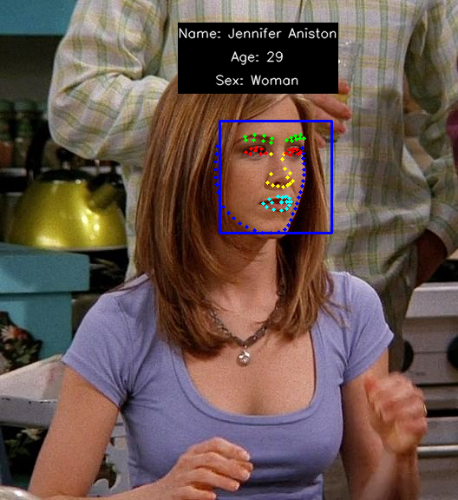

In [ ]:
## Testing Process
Test_Process()

In [ ]:
# Remove any current images
reset_saved_images()

All saved images have been deleted.
